In [216]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy
from scipy import interpolate

# Interpolation using Radial Basis Functions

# Assumptions
We start by stating the assumptions 

1. We are given $n$ locations $\vec x_j = [x_j,y_j], j=1,\ldots,n$ 
2. We know the value of a function $f_j = f(x_j,y_j)$ 
3. The function is assumed to be smooth 

Our goal is to approximate $f(x,y)$ such that we can estimate it at an arbitrary point.

# Question 4

Given radial function:
$$ \phi_j(x,y) = \left( {\frac {1}{1+\sigma[(x-x_j)^2 + (y-y_j)^2]}} \right). $$ 



Quesion:
* Reprogram the RBF interpolation such that it uses this function instead of the Gaussian we programmed inclass



In [217]:
def RBFfun(x,y,xI,yI,sigma):
    phi = 1/(1+ sigma*((x-xI)**2 + (y-yI)**2))
    return phi

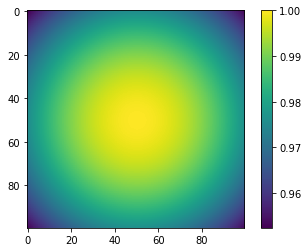

In [218]:
#Testing to see if RBF function works or not with random values and plotting

X, Y = torch.meshgrid([torch.arange(-50,50), torch.arange(-50,50)])
X = 0.01*X; Y = 0.01*Y
xj = 0.0; yj = 0.0; sigma = .1

Z = RBFfun(xj,yj,X,Y,sigma)

plt.imshow(Z)
plt.colorbar()

# Coding interpolation

The code involves setting up the matrix, sometimes refers to as the Kernel, setting up the right hand side and then solving it. Then, assuming we have the coefficients we interpolate the data to the point(s) we wish.

In [219]:
def RBFmatrix(x,y,sigma):
    # A = exp(d(xi,yi,xj,yj))
    n = x.shape[0]
    A = torch.zeros(n,n);
    for i in range(n):
        for j in range(n):
            A[i,j] = RBFfun(x[i],y[i],x[j],y[j],sigma);
    return A

In [220]:

def RBFmatrixFast(x,y,sigma):
  P = torch.cat((x.unsqueeze(1),y.unsqueeze(1)),dim=1)
  d = torch.sum(P**2,dim=1,keepdim=True)
  D = d + d.t() - 2*P@P.t()
  A = torch.exp(-D/sigma)
  return A

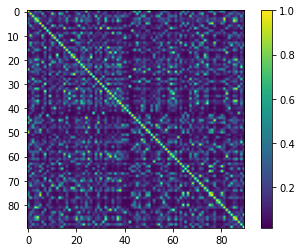

In [221]:
# Test the matrix
X = 6 * torch.rand(90) - 3
Y = 6 * torch.rand(90) - 3
sigma = 1.0
A = RBFmatrix(X,Y,sigma) #could use either Fast or Slow

plt.imshow(A); 
plt.colorbar()
plt.show()

# Using the matrix we now solve for the coefficients and interpolate

In [222]:
def RBFinterp(x,y,f,xI,yI,sigma):
# interpolate f(x,y) to f(xI,yI)  
    # Compute the RBF matrix
    A = RBFmatrixFast(x,y,sigma);

    # Compute the coefficients
    c, LU = torch.solve(f.unsqueeze(1),A)

    # Compute the data on the new points
    nI = xI.shape[0]
    n  = x.shape[0]
    vI = torch.zeros(nI)
    for i in range(nI):
        for j in range(n):
            vi = c[j]*RBFfun(x[j],y[j],xI[i],yI[i],sigma)
            vI[i] += vi[0];
    
    return vI

# Testing the code/ __Question 5__
* Given the function $f(x,y) = 3(1−x)^2*exp(−(x^2)−(y + 1)^2)−10(\frac{x}{5}−x^3−y^5)*exp(−x^2−y^2)−\frac {1}{3}*exp(−(x + 1)^2−y^2)$. Write code to use 90 random points across the function F in $[-3,3]^2$

https://stackoverflow.com/questions/44328530/how-to-get-a-uniform-distribution-in-a-range-r1-r2-in-pytorch

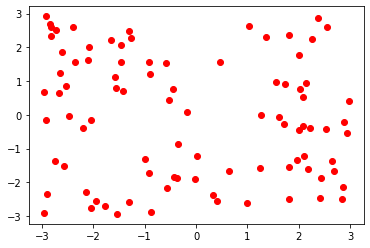

In [223]:
# Test the code
def fun2interp(X,Y):
    F = 3*(1-X)**2*torch.exp(-(X**2)-(Y+1)**2)-10*(X/5-Y**3-Y**5)*torch.exp(-X**2-X**2)-1/3*torch.exp(-(X+1)**2-Y**2)
    return F


x = 6 * torch.rand(90) - 3
y = 6 * torch.rand(90) - 3

Tobs = fun2interp(x,y)

plt.plot(x,y,'or')
plt.show()

## interpolate it to a regular grid $(x,y)$

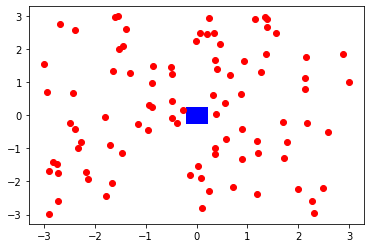

In [226]:
Xint, Yint = torch.meshgrid(x,y)
res = 0.05
Xint = res*Xint; Yint = res*Yint

plt.plot(Xint,Yint,'xb',X,Y,'or');

## We compute the RBF interpolation first

In [ ]:
sigma = 0.01
TiRBF = RBFinterp(x,y,Tobs,Xint.view(-1),Yint.view(-1),sigma);

In [ ]:
TiRBF = TiRBF.view(Xint.shape[0],Xint.shape[1])

## We now can plot the interpolated function

In [ ]:
Ttrue = fun2interp(Xint,Yint)
plt.subplot(1,3,1)
plt.imshow(TiRBF);
plt.subplot(1,3,2)
plt.imshow(Ttrue); 
plt.subplot(1,3,3)

err_max =torch.abs(Ttrue-TiRBF)
plt.imshow(err_max); 

print('Maximum error',torch.abs(Ttrue-TiRBF).max().item())

# __Q7__
* Divide the data randomly into60training points and30validation points to determine the bestσfor the problem.Prepare a graph of the error on the validation as a function ofσ. What is the optimalσfor the problem?

> Cross validation to choose $\sigma$.
To this end we need to have two sets of points. Training points $(x_T,y_T)$ and validating points $(x_V, y_V)$.
The points shoud be chosen from the same distributions, as below

In [ ]:
X = torch.randn(60)
Y = torch.randn(60)

F = fun2interp(X,Y)

k = 30
xT = X[:k]; yT = Y[:k]  # training
xV = X[k:]; yV = Y[k:]  # validating

fT = F[:k]
fV = F[k:]


In [ ]:
sigma = 0.1
# Use the point xT, yT to evaluate the function at xV and yV
fV_est = RBFinterp(xT,yT,fT,xV,yV,sigma)

# compare the error with the true function
err = torch.abs(fV - fV_est).max()

print('Maximum error = ', err)

In [ ]:
# Do the same as the above but loop over values of sigma
sigma = 1e-3
sig = torch.zeros(16)
r   = torch.zeros(16)
for i in range(16):
    fV_est = RBFinterp(xT,yT,fT,xV,yV,sigma)
    err = torch.abs(fV - fV_est).max()
    # compute interpolation and error and record sigma and the error
    sig[i] = sigma
    r[i]   = err
    sigma *= 2
    print(i)
    
# Print the optimal value of sigma

plt.loglog(sig,r)

In [ ]:
def particleFlow(x0,y0,dt,n,xobs,yobs,uobs,vobs):
  # integrating dX/dt = U(X) with obseved U from interpolation
  sigma = 0.5
  X = torch.zeros(n+1)
  Y = torch.zeros(n+1)
  X[0] = x0
  Y[0] = y0
  u = RBFinterp(xobs,yobs,uobs,x0,y0,sigma)
  v = RBFinterp(xobs,yobs,vobs,x0,y0,sigma)
  # take the first time step
  X[1] = X[0] + dt*u
  Y[1] = Y[0] + dt*v

  for i in range(1,n):  
    u = RBFinterp(xobs,yobs,uobs,X[i:i+1],Y[i:i+1],sigma)
    v = RBFinterp(xobs,yobs,vobs,X[i:i+1],Y[i:i+1],sigma)
    X[i+1] = X[i-1] + 2*dt*u
    Y[i+1] = Y[i-1] + 2*dt*v

  return X, Y

  

In [ ]:
xobs = torch.randn(5)
yobs = torch.randn(5)
uobs = xobs*torch.exp(-(xobs**2+yobs**2)/0.5) - yobs*torch.exp(-((xobs-0.5)**2+(yobs-0.5)**2))
vobs = xobs*yobs*torch.exp(-(xobs**2+yobs**2)/0.5)
x0 = torch.zeros(1)
y0 = torch.zeros(1)

X, Y = particleFlow(x0,y0,0.001,10000,xobs,yobs,uobs,vobs)


In [ ]:
plt.plot(X,Y)